In [1]:
model_checkpoint = "google/vit-base-patch16-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [2]:
from huggingface_hub import notebook_login

notebook_login()

### Load Data

In [3]:
from datasets import load_dataset
import os

In [4]:
dataset = load_dataset("imagefolder", data_dir=os.path.abspath('datasets'))

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
from datasets import load_metric

metric = load_metric("accuracy")

/tmp/ipykernel_165/1780215247.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
})

In [7]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label

{0: 'fake_turquoise', 1: 'turquoise'}

### Preprocessing the data

In [8]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor 

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [9]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [10]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [11]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [12]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x400>,
 'label': 0,
 'pixel_values': tensor([[[0.2314, 0.2314, 0.2314,  ..., 0.2314, 0.2314, 0.2314],
          [0.2314, 0.2314, 0.2314,  ..., 0.2314, 0.2314, 0.2314],
          [0.2314, 0.2314, 0.2314,  ..., 0.2314, 0.2314, 0.2314],
          ...,
          [0.2314, 0.2314, 0.2314,  ..., 0.2314, 0.2314, 0.2314],
          [0.2314, 0.2314, 0.2314,  ..., 0.2314, 0.2314, 0.2314],
          [0.2314, 0.2314, 0.2314,  ..., 0.2314, 0.2314, 0.2314]],
 
         [[0.2235, 0.2235, 0.2235,  ..., 0.2235, 0.2235, 0.2235],
          [0.2235, 0.2235, 0.2235,  ..., 0.2235, 0.2235, 0.2235],
          [0.2235, 0.2235, 0.2235,  ..., 0.2235, 0.2235, 0.2235],
          ...,
          [0.2235, 0.2235, 0.2235,  ..., 0.2235, 0.2235, 0.2235],
          [0.2235, 0.2235, 0.2235,  ..., 0.2235, 0.2235, 0.2235],
          [0.2235, 0.2235, 0.2235,  ..., 0.2235, 0.2235, 0.2235]],
 
         [[0.1922, 0.1922, 0.1922,  ..., 0.1922, 0.1922, 0.1922],
  

### Training the model

In [13]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-turquoise",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [16]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [17]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Detected kernel version 4.14.326, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [18]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.556400,0.107289,0.975000
1,0.118100,0.022283,0.995000
2,0.027500,0.012712,0.995000


***** train metrics *****
  epoch                    =        2.95
  total_flos               = 384521969GF
  train_loss               =      0.1823
  train_runtime            =  0:48:01.88
  train_samples_per_second =       1.874
  train_steps_per_second   =       0.015


In [19]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       2.95
  eval_accuracy           =      0.995
  eval_loss               =     0.0223
  eval_runtime            = 0:00:32.56
  eval_samples_per_second =      6.142
  eval_steps_per_second   =      0.215


In [ ]:
trainer.push_to_hub()

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

### Inference

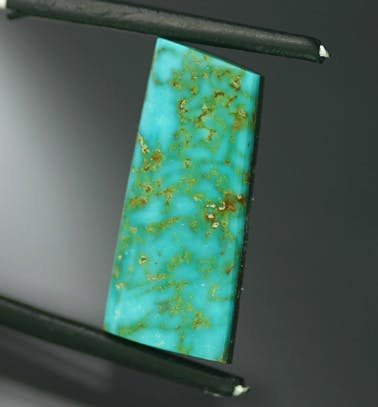

In [1]:
from PIL import Image
import requests

url = 'https://www.gemsociety.org/uploads/1200/75/2016/05/CTTurquoise.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [3]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "dzhao114/vit-base-patch16-224-finetuned-turquoise"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

2023-11-08 12:08:35.858490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [5]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [6]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted:", model.config.id2label[predicted_class_idx])

Predicted: turquoise
